In [2]:

import numpy as np
import scanpy as sc
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import pySTIM as pst

In [3]:
adata = sc.read_h5ad("../Xenium_all.h5ad")

In [4]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=None, use_raw=True, inplace=True)
qc_metrics = adata.obs[['n_genes_by_counts', 'total_counts']]
summary_stats = qc_metrics.agg(['mean', 'std']).transpose()
summary_stats['mean_std'] = summary_stats['mean'].astype(str) + " ± " + summary_stats['std'].astype(str)
print(summary_stats[['mean_std']])

                                                 mean_std
n_genes_by_counts  37.230139317703276 ± 16.24951698038563
total_counts        122.5668488597477 ± 96.70556082008775


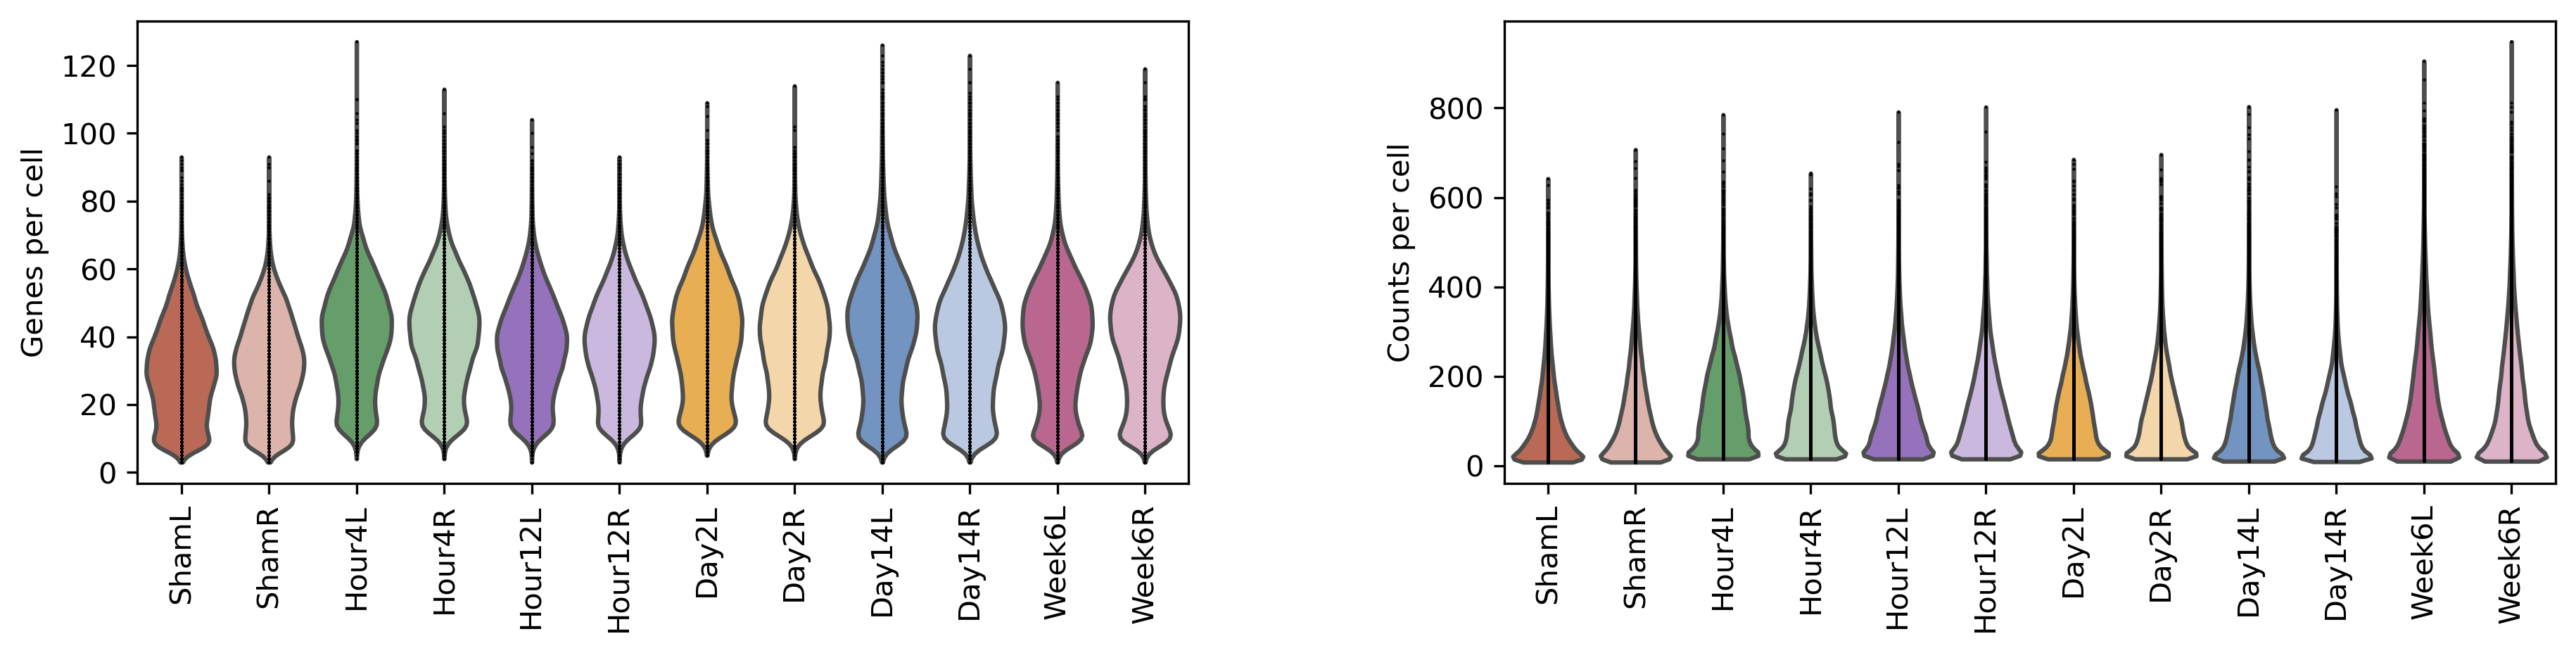

In [56]:
with plt.rc_context({"figure.figsize":(6,3), "figure.dpi":(300), "savefig.dpi":(300)}):
    ax = sc.pl.violin(adata, [ 'n_genes_by_counts', 'total_counts'], jitter=False, rotation=90, groupby = "ident", show=False)
    ax[0].set_ylabel("Genes per cell")
    ax[1].set_ylabel("Counts per cell")
    plt.savefig("Xenium_QC.png", transparent = True, bbox_inches='tight')
    plt.show()

In [9]:
adata_vis = sc.read_h5ad("../visium_IRI_R.h5ad")

In [12]:
sc.pp.calculate_qc_metrics(adata_vis, percent_top=None, log1p=None, use_raw=True, inplace=True)
qc_metrics = adata_vis.obs[['n_genes_by_counts', 'total_counts']]
summary_stats = qc_metrics.agg(['mean', 'std']).transpose()
summary_stats['mean_std'] = summary_stats['mean'].astype(str) + " ± " + summary_stats['std'].astype(str)
print(summary_stats[['mean_std']])

                                                 mean_std
n_genes_by_counts  5896.640471411662 ± 1279.7907408305705
total_counts              19351.70703125 ± 8997.787109375


In [18]:
adata_vis.uns['ident_colors'] = ['#CB5F46', '#E5AFA3', '#5ba862', '#ADD4B1', '#9565c9', '#CAB2E4',
       '#FFB43C', '#FFDA9E', '#6691ce', '#B3C8E7', '#C85990', '#E4ACC8']

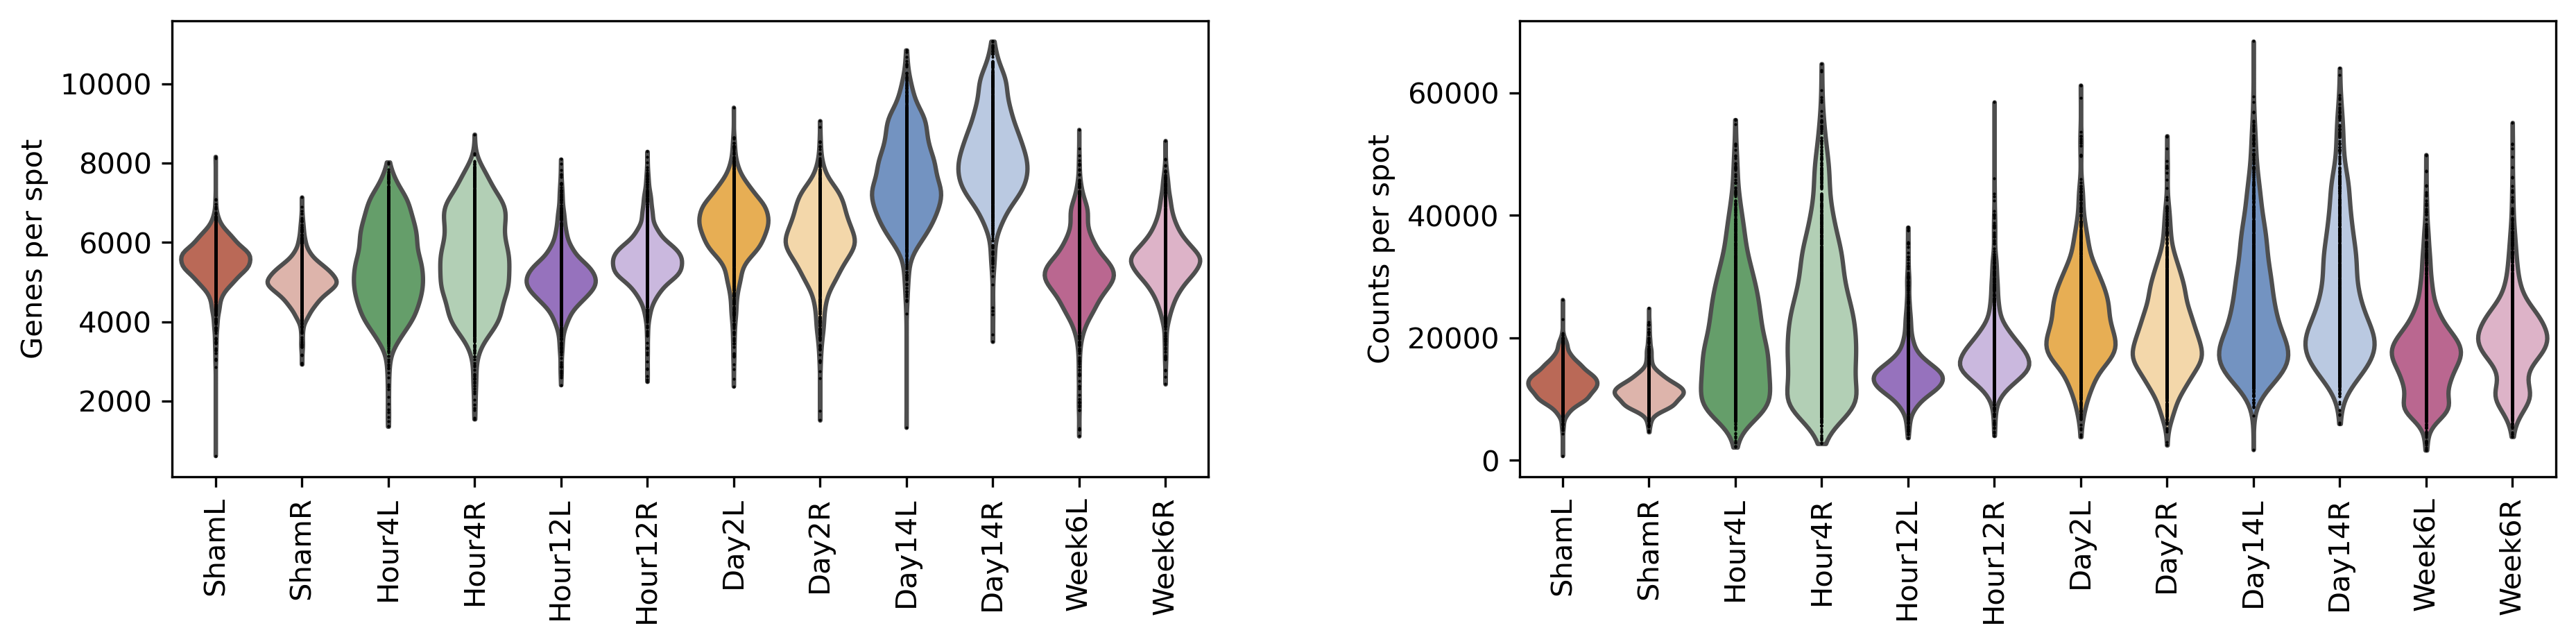

In [55]:
with plt.rc_context({"figure.figsize":(6,3), "figure.dpi":(300), "savefig.dpi":(300)}):
    ax = sc.pl.violin(adata_vis, [ 'n_genes_by_counts', 'total_counts'], jitter=False, rotation=90, groupby = "ident", show=False)
    ax[0].set_ylabel("Genes per spot")
    ax[1].set_ylabel("Counts per spot")
    plt.savefig("Visium_QC.png", transparent = True, bbox_inches='tight')
    plt.show()

In [5]:
pairs = adata.obs.ident.cat.categories.to_numpy().reshape(6,2)
groups = adata.obs['ident'].unique()
all_df = pd.concat(
    [pd.DataFrame(adata[adata.obs['ident'] == g].X.mean(axis=0), columns=adata.var_names, index=[g]) for g in groups]
)
all_df = all_df.T

color_list = ["#CB5F46", "#5ba862", "#9565c9", "#FFB43C", "#6691ce", "#C85990"]

In [6]:
correlations = []

for i, pair in enumerate(pairs):
    r = all_df[pair[0]].corr(all_df[pair[1]], method="pearson")
    correlations.append(r)


mean_corr = np.mean(correlations)
std_corr = np.std(correlations, ddof=1)  # ddof=1 for sample standard deviation
se_corr = std_corr / np.sqrt(len(correlations))  # SE = SD / sqrt(N)

print(f"Mean correlation: {mean_corr:.2f}")
print(f"Standard deviation of correlations: {std_corr:.2f}")
print(f"Standard error of the mean correlation: {se_corr:.2f}")
print(f"A comparative analysis with bulk RNA sequencing data confirmed a high correlation (r={mean_corr:.2f} ± {se_corr:.2f})")

Mean correlation: 0.99
Standard deviation of correlations: 0.01
Standard error of the mean correlation: 0.00
A comparative analysis with bulk RNA sequencing data confirmed a high correlation (r=0.99 ± 0.00)


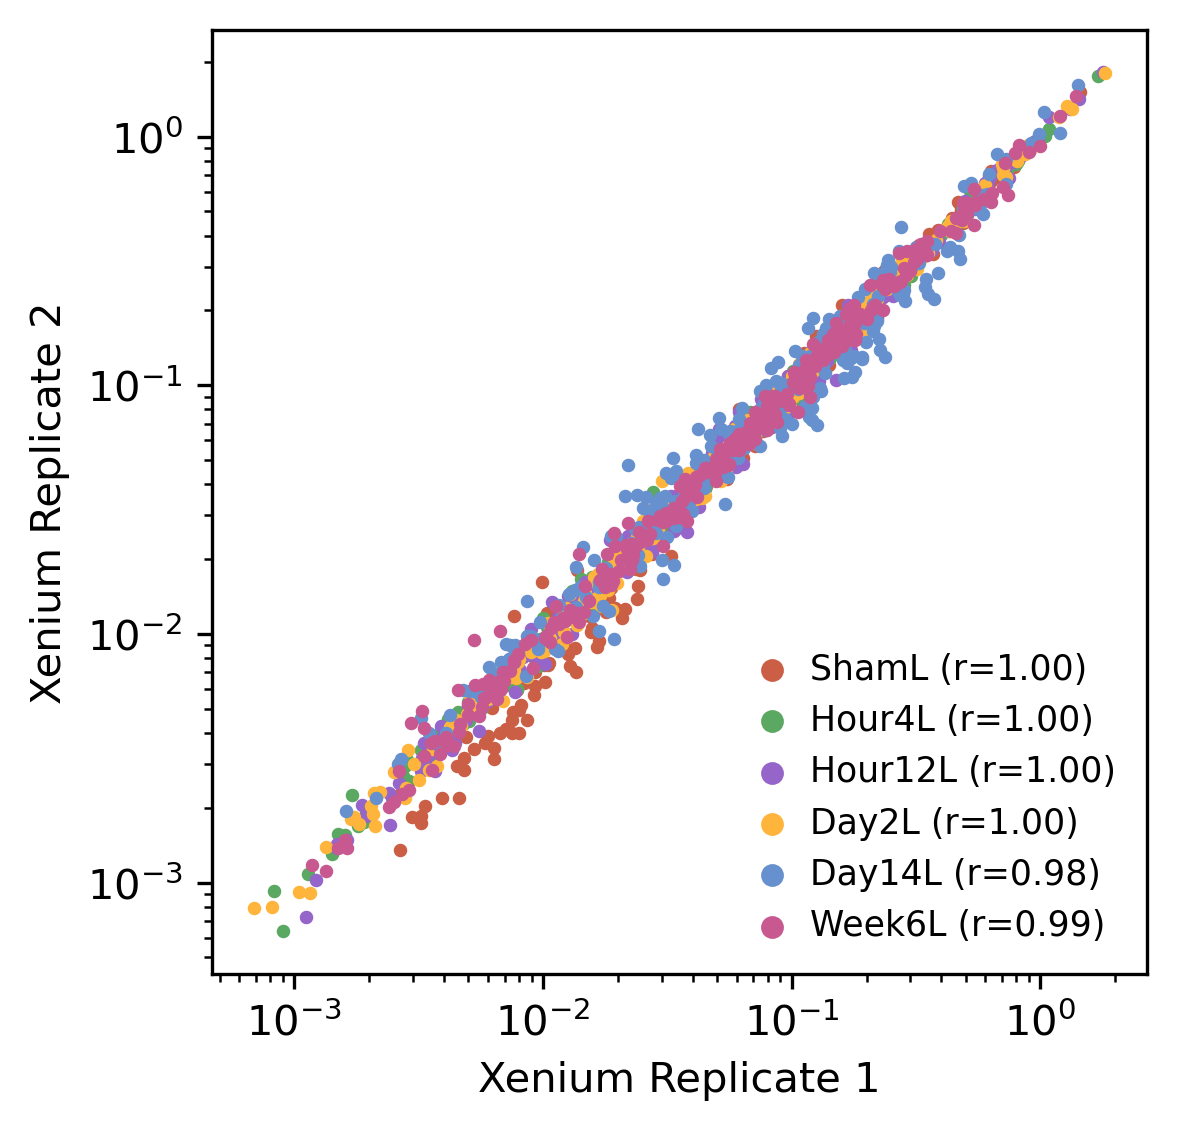

In [54]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

for i, pair in enumerate(pairs):
    r = all_df[pair[0]].corr(all_df[pair[1]], method="pearson")
    label = f'{pair[0].split("_")[0]} (r={r:.2f})'
    ax.scatter(all_df[pair[0]], all_df[pair[1]], color=color_list[i], s=5, label=label)
    
ax.set_xlabel("Xenium Replicate 1")
ax.set_ylabel("Xenium Replicate 2")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(markerscale=2, loc='lower right', fontsize="small", handletextpad = 0.1, frameon=False)
ax.set_aspect('equal')
ax.grid(False)
plt.tight_layout()
plt.savefig("Between_replicates_Xenium.png", transparent=True, bbox_inches='tight')
plt.show()

In [7]:
bulk_df = pd.read_csv("../bulk_meancounts.csv", index_col=0)

In [8]:
bulk_df 

,Sham,Hour4,Day2,Day14
Col5a2,0.129782,0.064190,0.230803,0.249847
Bmpr2,0.224211,0.059304,0.065343,0.061910
Nrp2,0.128998,0.063699,0.069450,0.118670
Erbb4,0.031139,0.009521,0.009537,0.010562
Inha,0.009900,0.002622,0.011592,0.009678
...,...,...,...,...
Sorcs3,0.006394,0.001820,0.001214,0.002455
Rbm20,0.028468,0.006602,0.012398,0.016101
Fgf13,0.005663,0.000898,0.000886,0.002567
Avpr2,0.001300,0.000147,0.000240,0.000320


In [9]:
for pair in pairs:
    name = pair[0][:-1]
    all_df[name] = (all_df[pair[0]]+all_df[pair[1]])/2

sp_df = all_df.loc[bulk_df.index,bulk_df.columns]

In [10]:
sp_df

,Sham,Hour4,Day2,Day14
Col5a2,0.042357,0.040564,0.166408,0.147296
Bmpr2,0.230184,0.254775,0.283703,0.300413
Nrp2,0.090283,0.123414,0.147949,0.134417
Erbb4,0.079611,0.066132,0.081218,0.124374
Inha,0.014316,0.012891,0.018869,0.032405
...,...,...,...,...
Sorcs3,0.008599,0.003956,0.002887,0.007639
Rbm20,0.034269,0.022944,0.020672,0.038014
Fgf13,0.004368,0.001833,0.002493,0.005468
Avpr2,0.042277,0.010749,0.015073,0.027930


In [11]:
time_points = ["Sham", "Hour4", "Day2", "Day14"]       
color_list = ["#CB5F46", "#5ba862", "#FFB43C", "#6691ce"]

In [12]:
correlations = []

for t in time_points:
    r = sp_df[t].corr(bulk_df[t], method="pearson")
    correlations.append(r)


mean_corr = np.mean(correlations)
std_corr = np.std(correlations, ddof=1)  # ddof=1 for sample standard deviation
se_corr = std_corr / np.sqrt(len(correlations))  # SE = SD / sqrt(N)

print(f"Mean correlation: {mean_corr:.2f}")
print(f"Standard deviation of correlations: {std_corr:.2f}")
print(f"Standard error of the mean correlation: {se_corr:.2f}")
print(f"A comparative analysis with bulk RNA sequencing data confirmed a high correlation (r={mean_corr:.2f} ± {se_corr:.2f})")

Mean correlation: 0.59
Standard deviation of correlations: 0.08
Standard error of the mean correlation: 0.04
A comparative analysis with bulk RNA sequencing data confirmed a high correlation (r=0.59 ± 0.04)


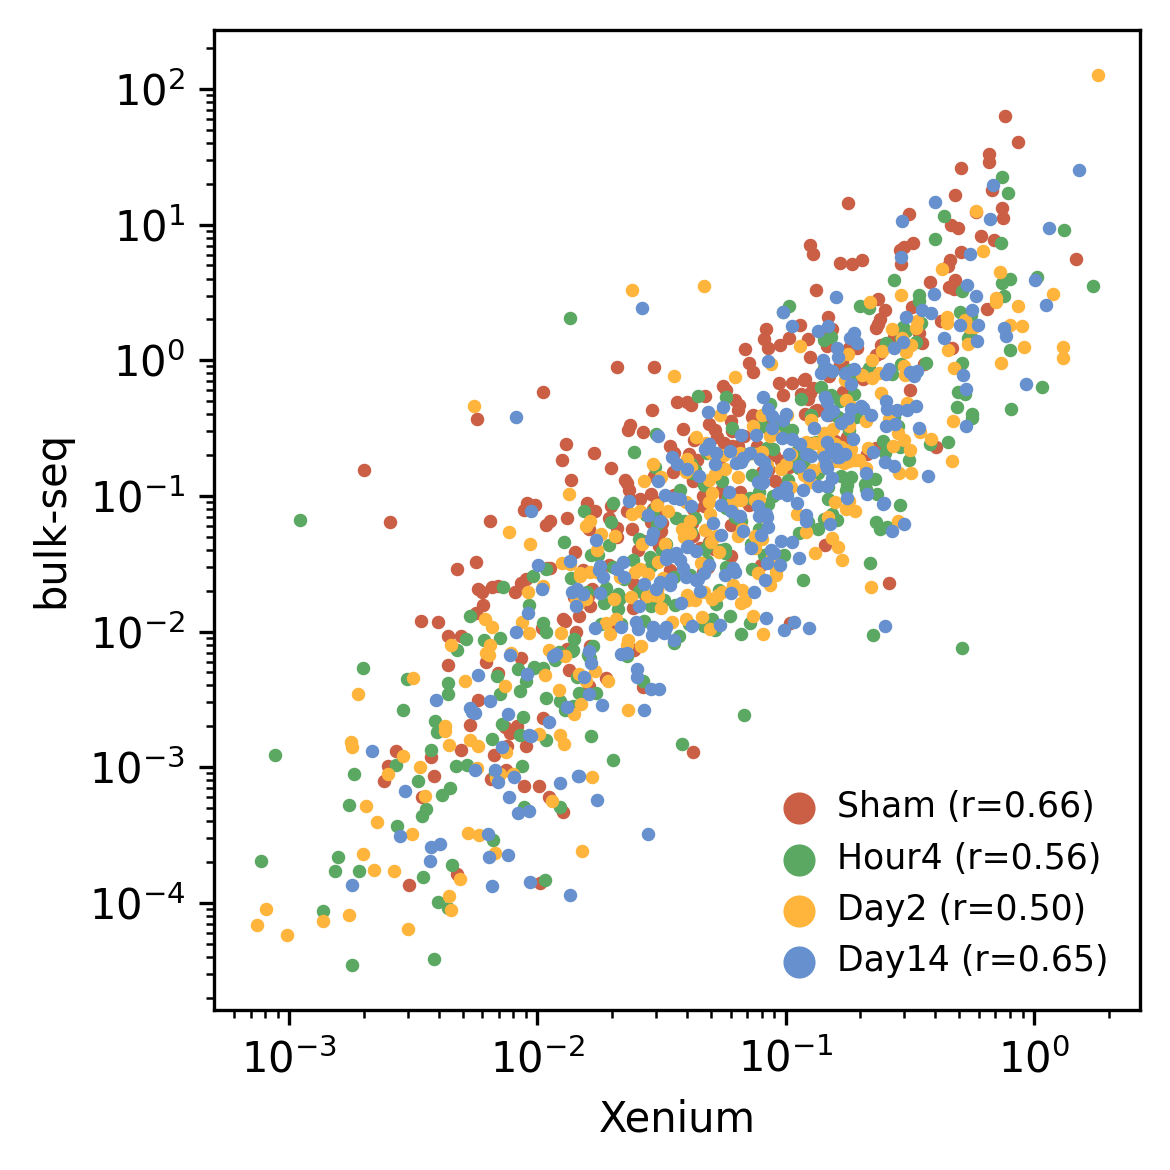

In [13]:

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

for i, t in enumerate(time_points):
    r_squared = sp_df[t].corr(bulk_df[t], method="pearson")
    label = f'{t} (r={r_squared:.2f})'
    ax.scatter(sp_df[t], bulk_df[t], color=color_list[i], s=5, label=label)
    
ax.set_xlabel("Xenium")
ax.set_ylabel("bulk-seq")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(markerscale=3, loc='lower right', fontsize='small', handletextpad = 0.1, frameon=False)
ax.grid(False)
plt.tight_layout()
plt.savefig("Between_bulkseq.png", transparent=True, bbox_inches='tight')
plt.show()